In [1]:
import xarray as xr

In [3]:
data = xr.open_dataset("data/2011_t2m_era5_2deg.nc")
data

<xarray.Dataset> Size: 95MB
Dimensions:     (valid_time: 1460, lon: 180, lat: 90)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 12kB 2011-01-01 ... 2011-12-31T18...
  * lon         (lon) float64 1kB 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * lat         (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
Data variables:
    t2m         (valid_time, lat, lon) float32 95MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.4.4 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Wed Jun 11 23:24:35 2025: cdo remapbil,r180x90 2...
    CDO:                     Climate Data Operators version 2.4.4 (https://mp...

In [ ]:
def extract_month(data):
    return 

In [11]:
data.valid_time.dt.month.values

array([ 1,  1,  1, ..., 12, 12, 12], shape=(1460,))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

weather_data = xr.open_dataset("data/2011_t2m_era5_2deg.nc").t2m.isel(valid_time=slice(0, 2)).values
# convert to tensor
weather_data = torch.tensor(weather_data)

B, l, L = weather_data.shape
# flatten to convert to tokens
weather_data = weather_data.reshape(B, l*L)

class BasicSelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.qkv = nn.Linear(embed_dim, 3*embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
    def forward(self, x):
        qkv = self.qkv(x)
        q, k, v = qkv.split(3, dim=-1)
        attn_weights = q @ k.transpose(-2, -1)
        attn_weights = attn_weights / math.sqrt(q.shape[-1])
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.out_proj(attn_weights)
        return attn_weights
        


In [20]:
B, l, L

(2, 90, 180)

In [15]:
weather_data.t2m.isel(valid_time=0).values

array([[246.6997 , 246.69385, 246.68799, ..., 246.74463, 246.729  ,
        246.71533],
       [247.52002, 247.4751 , 247.43018, ..., 247.52197, 247.49854,
        247.51025],
       [250.76611, 250.26807, 249.72314, ..., 251.37158, 251.1919 ,
        250.99072],
       ...,
       [244.43213, 244.16455, 243.84229, ..., 244.36377, 244.43018,
        244.44775],
       [243.59619, 243.6001 , 243.604  , ..., 243.03955, 243.16455,
        243.38135],
       [242.73291, 242.70557, 242.67627, ..., 242.52002, 242.59424,
        242.66455]], shape=(90, 180), dtype=float32)

In [9]:
import xarray as xr
import torch
import matplotlib.pyplot as plt
import torch
from models import DiT_models
from diffusion import create_diffusion

import numpy as np

data = xr.open_dataset("/p/project1/training2533/lancelin1/WeGenDiffusion/data/2011_t2m_era5_2deg.nc")


model_path = "/p/project1/training2533/lancelin1/WeGenDiffusion/results/DiT-B-2_previous_state_3/ckpt_0000070.pt"
data_path = "/p/project1/training2533/lancelin1/WeGenDiffusion/data/2011_t2m_era5_2deg.nc"
num_labels = 2
shape = (num_labels,1,90,180)
generate = True
output_name = 'previous_state'
axis_name = 'previous_state'
labels = "previous_state"
combine_imgs = False

if generate:
    model_state_dict = torch.load(model_path, map_location='cuda')['model']
    model = DiT_models['DiT-B/2'](input_size=(90,180),num_classes=1000, labels=labels).to('cuda')
    model.load_state_dict(model_state_dict,strict=True)
    model.eval()

    diffusion = create_diffusion(timestep_respacing="", diffusion_steps=100)
    # y = torch.arange(0, shape[0],dtype=torch.long,device='cuda')
    index = 0
    vars = ['t2m']
    mean = data.mean()
    std = data.std()
    y = np.concat([np.expand_dims((data.isel(valid_time=index+1)[var].values - mean[var].values)/std[var].values,axis=0) 
                            for var in vars])
    # add an extra dimension for the channels at first position
    # y is a 4D tensor (num_labels, 1, 90, 180)
    # co,nvert to torch tensor
    y = torch.tensor(y, dtype=torch.float32, device='cuda')
    y = y.reshape(1, 1, 90, 180)

    denoised_images = diffusion.p_sample_loop(model,shape,model_kwargs=dict(y=y), progress=True)
    # save the raw outputs since generation is expensive
    torch.save(denoised_images, f'{output_name}_samples.pt')

else:
    denoised_images = torch.load(f'{output_name}_samples.pt')

denoised_images = torch.squeeze(denoised_images, 1)

100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


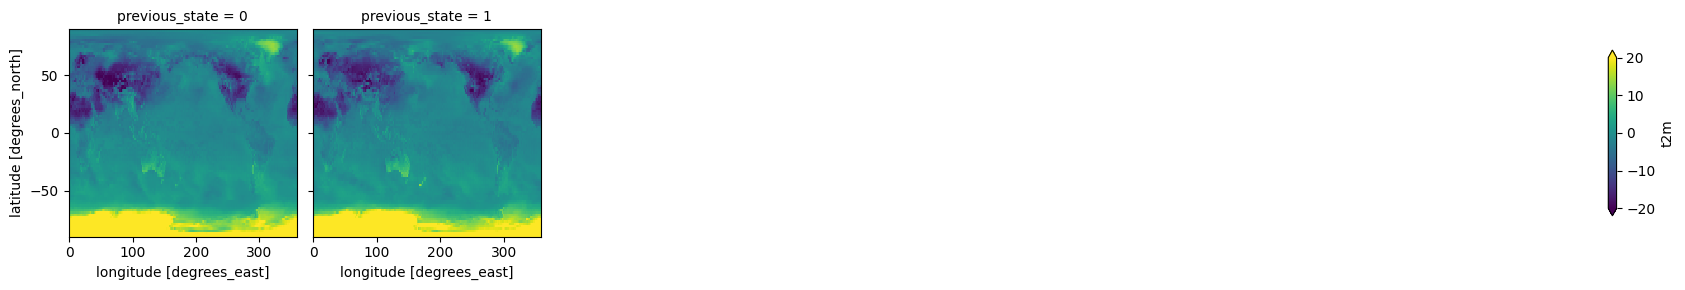

In [ ]:
ds = xr.open_dataset(data_path)
mean = ds.mean()['t2m'].values
std = ds.std()['t2m'].values
mean_field = data['t2m'].mean(dim='valid_time').values

samples = []
for i in range(shape[0]):
    samples.append(xr.Dataset({
    "t2m": (("lat", "lon"), mean + std*denoised_images[i].cpu().numpy()-mean_field)
    },
    coords={
        'lon':ds['lon'],
         'lat':ds['lat']}))

samples = [sample for sample in samples]
combined = xr.concat(samples,dim=axis_name)

combined["t2m"].plot(
    col=axis_name,
    col_wrap=6,
    cmap="viridis",
    cbar_kwargs={
        "orientation": "vertical",   # vertical colorbar at the side
        "pad": 0.05,                  # distance from the plots
        "shrink": 0.8                  # shrink length
    },
    vmin=-20,
    vmax=20
)

In [28]:
mean_field

<xarray.Dataset> Size: 67kB
Dimensions:  (lon: 180, lat: 90)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables:
    t2m      (lat, lon) float32 65kB 227.8 227.8 227.8 ... 259.6 259.6 259.7

In [24]:
samples['t2m']

TypeError: list indices must be integers or slices, not str

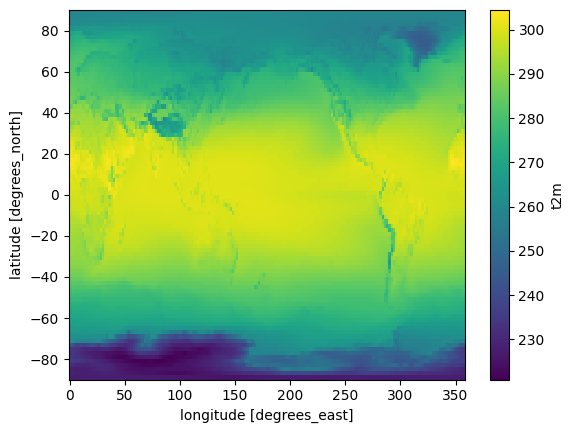

In [17]:
(combined["t2m"] - mean_field).plot(
    col=axis_name,
    col_wrap=6,
    cmap="viridis",
    cbar_kwargs={
        "orientation": "vertical",   # vertical colorbar at the side
        "pad": 0.05,                  # distance from the plots
        "shrink": 0.8                  # shrink length
    },
    vmin=-10,
    vmax=10
)

AttributeError: module 'xarray' has no attribute 'DataTree'

In [18]:
combined["t2m"] 

<xarray.DataArray 't2m' (previous_state: 2, lat: 90, lon: 180)> Size: 130kB
array([[[258.1207 , 257.77472, 258.11896, ..., 258.55008, 258.26624,
         258.26663],
        [259.12546, 258.90347, 258.81296, ..., 258.84183, 259.08453,
         258.927  ],
        [260.1812 , 259.84695, 260.22028, ..., 260.09277, 260.23157,
         260.4879 ],
        ...,
        [257.77792, 257.77472, 257.90958, ..., 257.77472, 257.77472,
         257.77472],
        [258.22623, 258.26306, 258.29263, ..., 257.93726, 257.86285,
         258.38736],
        [258.16382, 257.91904, 258.13397, ..., 258.1201 , 258.38397,
         258.05127]],

       [[258.7646 , 258.6129 , 258.66754, ..., 258.40677, 258.2968 ,
         258.54996],
        [259.18005, 259.17648, 259.10953, ..., 259.2515 , 259.29694,
         259.4633 ],
        [262.0913 , 261.47955, 261.04593, ..., 260.75314, 261.1503 ,
         261.73425],
        ...,
        [257.77472, 257.77472, 257.77472, ..., 257.80142, 257.835  ,
         257.77472],
        [258.87466, 258.85754, 258.83542, ..., 258.5347 , 258.42715,
         258.81717],
        [257.77472, 257.77472, 257.77472, ..., 257.77472, 257.77472,
         257.77472]]], shape=(2, 90, 180), dtype=float32)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: previous_state

In [6]:
data.valid_time.values

array(['2011-01-01T00:00:00.000000000', '2011-01-01T06:00:00.000000000',
       '2011-01-01T12:00:00.000000000', ...,
       '2011-12-31T06:00:00.000000000', '2011-12-31T12:00:00.000000000',
       '2011-12-31T18:00:00.000000000'],
      shape=(1460,), dtype='datetime64[ns]')

In [2]:
import xarray as xr
import torch
import matplotlib.pyplot as plt
import torch
from models import DiT_models
from diffusion import create_diffusion
import numpy as np



data = xr.open_dataset("/p/project1/training2533/lancelin1/WeGenDiffusion/data/2011_t2m_era5_2deg.nc")


model_path = "/p/project1/training2533/lancelin1/WeGenDiffusion/results/DiT-B-2_previous_state_3/ckpt_0000080.pt"
data_path = "/p/project1/training2533/lancelin1/WeGenDiffusion/data/2011_t2m_era5_2deg.nc"
num_rollouts = 28

indices = [0, 100, 200]
num_indices = len(indices)
shape = (num_indices,1,90,180)
output_name = 'previous_state_test1'
axis_name = 'previous_state'
labels = "previous_state"
combine_imgs = False
vars = ['t2m']




model_state_dict = torch.load(model_path, map_location='cuda')['model']
model = DiT_models['DiT-B/2'](input_size=(90,180),num_classes=1000, labels=labels).to('cuda')
model.load_state_dict(model_state_dict,strict=True)
model.eval()

mean = data.mean()
std = data.std()
y = np.concat([np.expand_dims((data.isel(valid_time=index+1)[var].values - mean[var].values)/std[var].values,axis=0) 
                            for var in vars for index in indices])
for i in range(num_rollouts):
    print(f"Rollout {i+1} of {num_rollouts}")
    diffusion = create_diffusion(timestep_respacing="", diffusion_steps=100)
    vars = ['t2m']

    print(y.shape)
    y = torch.tensor(y, dtype=torch.float32, device='cuda')
    y = y.reshape(num_indices, 1, 90, 180)
    print(y.shape)

    denoised_images = diffusion.p_sample_loop(model,shape,model_kwargs=dict(y=y), progress=True)
    y = denoised_images
    # save the raw outputs since generation is expensive
    # convert to numpy array
    denoised_images = denoised_images.cpu().numpy()
    print(denoised_images)
    np.save(f'samples/forecast/{output_name}_rollout_{i}.npy', denoised_images)
     


# denoised_images = torch.squeeze(denoised_images, 1)

Rollout 1 of 28
(3, 90, 180)
torch.Size([3, 1, 90, 180])


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]
/tmp/ipykernel_235748/1767466663.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32, device='cuda')


[[[[-1.         -0.99626726 -1.         ... -0.9940759  -0.99945706
    -0.9990631 ]
   [-0.9855484  -0.9749586  -0.98429775 ... -0.9639917  -0.96740264
    -0.967017  ]
   [-1.         -0.99872416 -1.         ... -0.99977624 -1.
    -1.        ]
   ...
   [-0.9786192  -0.9755302  -0.97946507 ... -0.98706406 -0.9807042
    -0.9743803 ]
   [-0.9373214  -0.9313879  -0.9313586  ... -0.9800012  -0.963309
    -0.9595039 ]
   [-1.         -0.99761194 -1.         ... -1.         -1.
    -1.        ]]]


 [[[-0.9565497  -0.94369006 -0.9414908  ... -0.94259554 -0.96337855
    -0.95969534]
   [-0.88897246 -0.8743943  -0.88961226 ... -0.9031129  -0.917917
    -0.90078413]
   [-0.9554998  -0.95333767 -0.98996186 ... -0.95051265 -0.95093256
    -0.9441121 ]
   ...
   [-0.99249864 -0.97147876 -0.9750241  ... -1.         -1.
    -0.9955792 ]
   [-1.         -0.98857874 -1.         ... -0.9976355  -1.
    -0.99912345]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]]]


 [[

100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


[[[[-0.9899975  -0.9838173  -1.         ... -0.9772401  -0.98428833
    -0.99144083]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-0.9953277  -0.992904   -1.         ... -0.9973784  -0.9990253
    -0.9910522 ]
   ...
   [-1.         -0.98186177 -0.9778275  ... -1.         -1.
    -1.        ]
   [-0.9259332  -0.9182037  -0.9265382  ... -0.937889   -0.94152856
    -0.9295949 ]
   [-0.89545065 -0.870417   -0.8943618  ... -0.8841144  -0.89467657
    -0.87626624]]]


 [[[-0.97480524 -0.9907094  -0.98767626 ... -0.9800862  -0.98102635
    -0.9852589 ]
   [-0.97669107 -0.95598733 -0.99406433 ... -0.94812    -0.96871865
    -0.95064014]
   [-0.97747797 -0.9912154  -0.99664664 ... -0.96974844 -0.9784751
    -0.97520036]
   ...
   [-0.94716257 -0.92639214 -0.9411502  ... -0.9182894  -0.9266048
    -0.9113503 ]
   [-0.8285174  -0.81593823 -0.83605576 ... -0.8272247  -0.84270287
    -0.82845193]
   [-0.73575497 -0.70758116 -0.7390995  ... -0.7025156  -0.7284145

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


[[[[-0.98267347 -0.9924982  -0.98760384 ... -0.9994212  -0.9954847
    -0.995004  ]
   [-0.98127586 -0.9773038  -0.99661493 ... -0.9833396  -0.9893085
    -0.9737865 ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   ...
   [-0.9435346  -0.93856484 -0.9200228  ... -0.9789107  -0.95622957
    -0.94788957]
   [-0.8385118  -0.83494025 -0.8410881  ... -0.8454071  -0.84488404
    -0.8347129 ]
   [-0.6934122  -0.6778581  -0.6848082  ... -0.7086588  -0.70278764
    -0.69685394]]]


 [[[-0.9538045  -0.97396743 -0.9640523  ... -0.98529077 -0.9597871
    -0.9764089 ]
   [-0.97368497 -0.9645879  -0.99343866 ... -0.964634   -0.9695204
    -0.96113133]
   [-0.9449768  -0.9706128  -0.98345345 ... -0.93592805 -0.9414397
    -0.94910663]
   ...
   [-0.8492183  -0.81890535 -0.80070096 ... -0.8786934  -0.875096
    -0.85201937]
   [-0.69843614 -0.6860831  -0.69904906 ... -0.7115559  -0.71574825
    -0.7120034 ]
   [-0.7667852  -0.74556124 -0.770336   ... -0.769725   -0.784

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


[[[[-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -0.9952484  -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -0.999219
    -1.        ]
   ...
   [-0.5636501  -0.5483341  -0.56372124 ... -0.5604173  -0.5725045
    -0.5554635 ]
   [-0.5833921  -0.5878214  -0.5895592  ... -0.58507144 -0.5845602
    -0.5980246 ]
   [-0.6056299  -0.5890606  -0.61281437 ... -0.60824186 -0.61373
    -0.60266846]]]


 [[[-0.9353009  -0.9619     -0.95931935 ... -0.96335965 -0.93635905
    -0.9702772 ]
   [-0.95908326 -0.9564594  -0.964127   ... -0.9337595  -0.95508635
    -0.98469216]
   [-0.99565184 -1.         -1.         ... -1.         -1.
    -1.        ]
   ...
   [-0.3535399  -0.3330387  -0.35967362 ... -0.3770532  -0.35620323
    -0.336609  ]
   [-0.38517824 -0.39311647 -0.39569154 ... -0.3888166  -0.3790066
    -0.37959325]
   [-0.41729653 -0.41162947 -0.43041673 ... -0.41998565 -0.42325336
    -0.4194

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


[[[[-0.9892246  -1.         -1.         ... -0.980466   -1.
    -1.        ]
   [-1.         -1.         -1.         ... -0.989246   -0.9994386
    -0.9902938 ]
   [-0.9544826  -0.988575   -0.9779406  ... -1.         -0.98463637
    -0.9924455 ]
   ...
   [-0.36973166 -0.3629434  -0.38374615 ... -0.32763743 -0.33151615
    -0.33462888]
   [-0.36671105 -0.39338002 -0.39051187 ... -0.38830283 -0.36715445
    -0.3870369 ]
   [-0.41783804 -0.40185025 -0.4186405  ... -0.3941293  -0.40412274
    -0.38929266]]]


 [[[-0.97122574 -0.9900025  -0.9880499  ... -0.99543387 -0.95828533
    -0.97287476]
   [-0.99273837 -1.         -1.         ... -0.9505475  -0.96878564
    -0.9724778 ]
   [-0.98623836 -0.9808512  -1.         ... -0.9862761  -0.9945868
    -1.        ]
   ...
   [-0.2808996  -0.27494726 -0.27305433 ... -0.25581667 -0.2979746
    -0.2816874 ]
   [-0.29209667 -0.2933564  -0.27736473 ... -0.31823984 -0.30640724
    -0.30752277]
   [-0.31726372 -0.31165817 -0.31057954 ... -0.31019336 -0

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


[[[[-1.         -1.         -0.99844116 ... -1.         -1.
    -1.        ]
   [-0.99198467 -0.9661288  -1.         ... -0.99935913 -1.
    -0.9922318 ]
   [-0.983276   -0.9751317  -0.99757516 ... -1.         -1.
    -1.        ]
   ...
   [-0.3142482  -0.28611636 -0.32363722 ... -0.29643285 -0.31650883
    -0.29679835]
   [-0.27385813 -0.2764569  -0.2910042  ... -0.28905955 -0.3019657
    -0.29024208]
   [-0.35073137 -0.3250005  -0.35103285 ... -0.35578647 -0.35574216
    -0.33992574]]]


 [[[-0.99699026 -0.99117863 -1.         ... -1.         -0.9964651
    -0.99901694]
   [-1.         -1.         -1.         ... -0.9921477  -1.
    -1.        ]
   [-0.9895229  -0.9875491  -1.         ... -1.         -0.992163
    -0.99028206]
   ...
   [-0.25563416 -0.2412751  -0.24472879 ... -0.23380807 -0.25011924
    -0.2375117 ]
   [-0.24076377 -0.25492013 -0.24942106 ... -0.27217317 -0.2651118
    -0.27193597]
   [-0.2872368  -0.26892287 -0.29111776 ... -0.28322715 -0.29022723
    -0.27820414]

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


[[[[-0.9919494  -0.9973011  -1.         ... -1.         -0.99909747
    -1.        ]
   [-0.9999432  -1.         -1.         ... -0.9970008  -0.96220565
    -0.9831875 ]
   [-0.9919901  -0.9929701  -1.         ... -0.99052006 -0.97836155
    -0.97642654]
   ...
   [-0.23427671 -0.24427876 -0.24759223 ... -0.24613786 -0.24624129
    -0.2582074 ]
   [-0.25918883 -0.27851167 -0.2541139  ... -0.2893549  -0.2612707
    -0.2796587 ]
   [-0.2917922  -0.29805112 -0.29073137 ... -0.3119943  -0.29611456
    -0.30474457]]]


 [[[-0.97270226 -0.99776393 -1.         ... -1.         -1.
    -1.        ]
   [-0.99432874 -0.99526495 -1.         ... -0.9669228  -0.9787735
    -0.9417302 ]
   [-0.9622656  -0.9656559  -0.9824942  ... -1.         -1.
    -1.        ]
   ...
   [-0.23500693 -0.23128048 -0.2308003  ... -0.23286706 -0.23838358
    -0.23383576]
   [-0.22170483 -0.21260233 -0.22093217 ... -0.23970981 -0.24375518
    -0.24228007]
   [-0.22632074 -0.22677681 -0.24648803 ... -0.22934929 -0.255629

100%|██████████| 100/100 [00:47<00:00,  2.13it/s]


[[[[-0.97451997 -0.99889815 -1.         ... -1.         -0.9962451
    -0.99171805]
   [-0.97113556 -0.95480174 -1.         ... -0.94288325 -0.93155545
    -0.91114616]
   [-1.         -1.         -1.         ... -0.9993286  -0.9904292
    -1.        ]
   ...
   [-0.2461304  -0.23956746 -0.24949169 ... -0.26472616 -0.2717472
    -0.25635862]
   [-0.23400219 -0.25700602 -0.23941317 ... -0.25583538 -0.25003663
    -0.25954482]
   [-0.27225727 -0.2644672  -0.2683835  ... -0.28979537 -0.2700069
    -0.27863872]]]


 [[[-0.95403534 -0.93904966 -0.98006546 ... -0.9623649  -0.9898726
    -0.98111033]
   [-1.         -1.         -1.         ... -0.9959528  -0.9786265
    -0.99199855]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   ...
   [-0.20676276 -0.20514579 -0.20866781 ... -0.23200285 -0.2291398
    -0.22746067]
   [-0.23025478 -0.24404143 -0.23696409 ... -0.24460219 -0.23305586
    -0.24227548]
   [-0.27629316 -0.27103448 -0.27769467 ... -0.26281807 -0.275

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


[[[[-0.9723777  -0.98490465 -0.98924917 ... -0.9936111  -1.
    -1.        ]
   [-1.         -1.         -1.         ... -0.9914351  -0.99008864
    -1.        ]
   [-1.         -1.         -0.9948166  ... -1.         -0.9789134
    -0.990404  ]
   ...
   [-0.21578082 -0.21702841 -0.20579007 ... -0.23118    -0.21008752
    -0.22399372]
   [-0.24806741 -0.26258144 -0.24501058 ... -0.23991276 -0.24060002
    -0.25051162]
   [-0.25103596 -0.25866923 -0.25905475 ... -0.24773447 -0.23944494
    -0.24989113]]]


 [[[-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-0.98858935 -0.9875124  -1.         ... -0.97903776 -0.97616357
    -0.95524144]
   [-0.9992846  -0.9980692  -0.99590105 ... -1.         -1.
    -1.        ]
   ...
   [-0.21252692 -0.18938595 -0.22323415 ... -0.21209638 -0.20982572
    -0.2025419 ]
   [-0.20247206 -0.18402298 -0.20774332 ... -0.20191029 -0.2140463
    -0.1908088 ]
   [-0.24444641 -0.235343   -0.2259149  ... -0.23810004 -0.24709095
    -

 66%|██████▌   | 66/100 [00:31<00:16,  2.10it/s]


KeyboardInterrupt: 

In [55]:
path = "/p/project1/training2533/lancelin1/WeGenDiffusion/samples/forecast/previous_state_test1_rollout_0.npy"
samples_gen = np.load(path)
samples_gen = samples_gen.squeeze(1)
samples_gen.shape

(3, 90, 180)

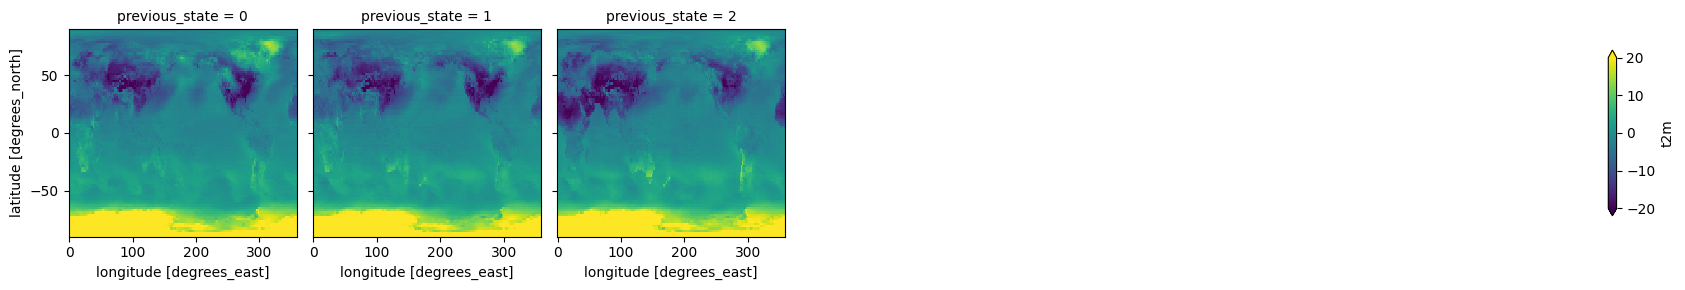

In [56]:
ds = xr.open_dataset(data_path)
mean = ds.mean()['t2m'].values
std = ds.std()['t2m'].values
mean_field = data['t2m'].mean(dim='valid_time').values

samples = []
for i in range(shape[0]):
    samples.append(xr.Dataset({
    "t2m": (("lat", "lon"), mean + std*samples_gen[i]-mean_field)
    },
    coords={
        'lon':ds['lon'],
         'lat':ds['lat']}))

samples = [sample for sample in samples]
combined = xr.concat(samples,dim=axis_name)

combined["t2m"].plot(
    col=axis_name,
    col_wrap=6,
    cmap="viridis",
    cbar_kwargs={
        "orientation": "vertical",   # vertical colorbar at the side
        "pad": 0.05,                  # distance from the plots
        "shrink": 0.8                  # shrink length
    },
    vmin=-20,
    vmax=20
)

In [57]:
data

<xarray.Dataset> Size: 95MB
Dimensions:     (valid_time: 1460, lon: 180, lat: 90)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 12kB 2011-01-01 ... 2011-12-31T18...
  * lon         (lon) float64 1kB 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * lat         (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
Data variables:
    t2m         (valid_time, lat, lon) float32 95MB 246.7 246.7 ... 248.7 249.1
Attributes:
    CDI:                     Climate Data Interface version 2.4.4 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Wed Jun 11 23:24:35 2025: cdo remapbil,r180x90 2...
    CDO:                     Climate Data Operators version 2.4.4 (https://mp...